<a href="https://colab.research.google.com/github/satyendra2013/Skin-Cancer-Classifier/blob/master/Skin_Cancer_Classifier_Version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Skin Cancer Classification Using Deep Neural Network**

Skin cancer is one of the common human malignancy, is primarily diagnosed visually, beginning with an initial clinical screening and followed potentially by dermoscopic analysis, a biopsy and histopathological examination. Automated classification of skin lesions using images is a challenging task owing to the fine-grained variability in the appearance of skin lesions.

Here I am using HAM10000 ("Human Against Machine with 10000 training images") dataset, which I downloaded from [Kaagle](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000).It consists of 10015 dermatoscopicimages which are released as a training set for academic machine learning purposes and are publiclyavailable through the ISIC archive. This benchmark dataset can be used for machine learning and for comparisons with human experts.

It has 7 different classes of skin cancer which are listed below :

  1: Actinic Keratoses
  2: Basal cell carcinoma
  3: Benign keratosis
  4: Dermatofibroma
  5: Melanoma
  6: Melanocytic nevi
  7: Vascular skin lesions

In this notebook, I have tried to implement a skin cancer analyzer using CNN with PyTorch. It is a side project of mine under Udacity & Facebook's PyTorch Challenge Scholarship 2018/19. 

##Note

Download the restructured HAM10000 Skin Cancer Dataset from this link https://drive.google.com/open?id=1hO42zUHH6AJeWfvFacbCieiChZ72VGUv and Upload the folder into drive and mount it to access this note book.

## Mounting the drive to access the dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Installing pytorch and torchvision

In [0]:
# Imports here
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# Let's verify the version
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime
!pip install PIL
!pip install image
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
import PIL
print(PIL.PILLOW_VERSION)

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
5.3.0


## Installing essential libraries

In [0]:
#import libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists

In [0]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Data Augmentation Steps



In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train_dir': transforms.Compose([
           transforms.RandomRotation(45),
           transforms.RandomResizedCrop(224),
           transforms.RandomHorizontalFlip(),
           transforms.ToTensor(),
           transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
    ]),
    'val_dir': transforms.Compose([
           transforms.Resize(256),
           transforms.CenterCrop(224),
           transforms.ToTensor(),
           transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
     ]),
        
      'test_dir': transforms.Compose([
           transforms.Resize(256),
           transforms.CenterCrop(224),
           transforms.ToTensor(),
           transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
      ])
}

data_dir = 'drive/My Drive/Cancer'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train_dir', 'val_dir', 'test_dir']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train_dir', 'val_dir', 'test_dir']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train_dir', 'val_dir', 'test_dir']}
class_names = image_datasets['train_dir'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Here, I have created a json file for labelling.

In [0]:
import json

with open('drive/My Drive/Cancer/can_to_name.json', 'r') as f:
    can_to_name = json.load(f)

## Model Architecture



In [0]:
# TODO: Build and train your network

# Load resnet-152 pre-trained network
model = models.resnet152(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## ResNet152 Pretrained Model

Here, I am using resnet152 pretrained model. Hyperparameters used are listed below:

*   Dropout = 0.5 #While building the model, I didn't use dropout but we can use dropout to avoid overfitting.
*   Learning Rate = 0.001
*   LR Scheduler : Decay LR by a factor of 0.1 every 5 epochs






In [0]:

# our input_size matches the in_features of pretrained model
from collections import OrderedDict

# creating the classifier ordered dictionary first
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu1', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(512, 7)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# replacing the pretrained model classifier with our classifier
model.fc = classifier

# Train a model with a pre-trained network
model = model.to(device)

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## Training Model

Here, I decided to train it for only 15 epochs, which can be increased to more number of epochs.

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train_dir', 'val_dir']:
            if phase == 'train_dir':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train_dir'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train_dir':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val_dir' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train_dir Loss: 0.8755 Acc: 0.6934
val_dir Loss: 0.4326 Acc: 0.8399

Epoch 1/14
----------
train_dir Loss: 0.7405 Acc: 0.7298
val_dir Loss: 0.4164 Acc: 0.8537

Epoch 2/14
----------
train_dir Loss: 0.7038 Acc: 0.7401
val_dir Loss: 0.3474 Acc: 0.8812

Epoch 3/14
----------
train_dir Loss: 0.6838 Acc: 0.7471
val_dir Loss: 0.3352 Acc: 0.8865

Epoch 4/14
----------
train_dir Loss: 0.6627 Acc: 0.7535
val_dir Loss: 0.3553 Acc: 0.8791

Epoch 5/14
----------
train_dir Loss: 0.6070 Acc: 0.7758
val_dir Loss: 0.3174 Acc: 0.8918

Epoch 6/14
----------
train_dir Loss: 0.5999 Acc: 0.7745
val_dir Loss: 0.3098 Acc: 0.8971

Epoch 7/14
----------
train_dir Loss: 0.5900 Acc: 0.7802
val_dir Loss: 0.3081 Acc: 0.8897

Epoch 8/14
----------
train_dir Loss: 0.5880 Acc: 0.7843
val_dir Loss: 0.3009 Acc: 0.8940

Epoch 9/14
----------
train_dir Loss: 0.5994 Acc: 0.7759
val_dir Loss: 0.3006 Acc: 0.8961

Epoch 10/14
----------
train_dir Loss: 0.5789 Acc: 0.7850
val_dir Loss: 0.3052 Acc: 0.8918

## Accuracy Check

In this step, I am checking accuracy of model on validation dataset only. Later, I will incorporate test dataset.

In [0]:
# TODO: Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['test_dir']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
      
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test_dir'])))



In [0]:
test(model, dataloaders, device)

Testing Accuracy: 0.234
Testing Accuracy: 0.526


## Save the checkpoint

In [0]:
# TODO: Save the checkpoint 

model.class_to_idx = dataloaders['train_dir'].dataset.class_to_idx
model.epochs = 15
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': 32,
                  'output_size': 7,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, 'cancer_classifier_checkpointV1.pth')

## Loading the checkpoint and rebuilding the model again.

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152(pretrained=True)
    
    # Our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 7
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(512, 7)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

# Get index to class mapping
loaded_model, class_to_idx = load_checkpoint('cancer_classifier_checkpointV1.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

## Processing the image for use in pytorch model

You'll want to use PIL to load the image. It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the thumbnail or resize methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so np_image = np.array(pil_image).

As before, the network expects the images to be normalized in a specific way. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225]. You'll want to subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using ndarray.transpose. The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    image_pil = Image.open(image)
   
    adjustment_in_image = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    
    image_tensor =adjustment_in_image(image_pil)
    
    return image_tensor

In [0]:
# Process a PIL image for use in a PyTorch model
img = ('drive/My Drive/Cancer/test_dir/6/ISIC_0024306.jpg') 
img = process_image(img)
print(img.shape)

torch.Size([3, 224, 224])


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your process_image function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

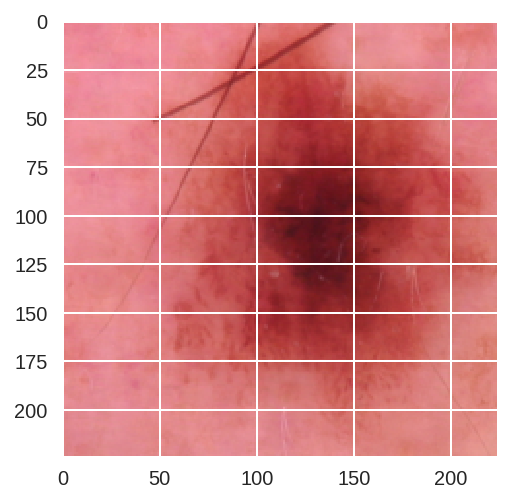

In [0]:
imshow(process_image('drive/My Drive/Cancer/test_dir/6/ISIC_0024306.jpg')) 

## Class Prediction
Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top- K ) most probable classes. You'll want to calculate the class probabilities then find the  K  largest values.

To get the top  K  largest values in a tensor use x.topk(k). This method returns both the highest k probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using class_to_idx which hopefully you added to the model or from an ImageFolder you used to load the data (see here). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']

In [0]:

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    
    image_path: string. Path to image, directly to image and not to folder.
    model: pytorch neural network.
    top_k: integer. The top K classes to be calculated
    
    returns top_probabilities(k), top_labels
    '''
    
    #There is no requirement to use GPU here. We can use cpu also.
    model.to("cuda")
    #model.to("cpu")
    
    # Setting the model to evaluation mode
    model.eval();

    # Convert image from numpy to torch
    torch_image = torch.from_numpy(np.expand_dims(process_image(image_path), 
                                                  axis=0)).type(torch.FloatTensor).to("cuda")

    # Find probabilities (results) by passing through the forward function of model on log scale
    log_probability = model.forward(torch_image)

    # Converting log_probability to linear scale
    linear_probability = torch.exp(log_probability)

    # Getting  the top 5 results
    top_probability, top_labels = linear_probability.topk(topk)
    
    # Detatch all of the details
    top_probability = np.array(top_probability.detach())[0] 
    top_labels = np.array(top_labels.detach())[0]
    
    # Convert to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[project] for project in top_labels]
    top_cancers = [can_to_name[project] for project in top_labels]
    
    return top_probability, top_labels, top_cancers

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Here, I am using matplotlib & seaborn to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

You can convert from the class integer encoding to actual cancer names with the can_to_name.json file (loaded earlier in this notebook). To show a PyTorch tensor as an image, use the imshow function defined above.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


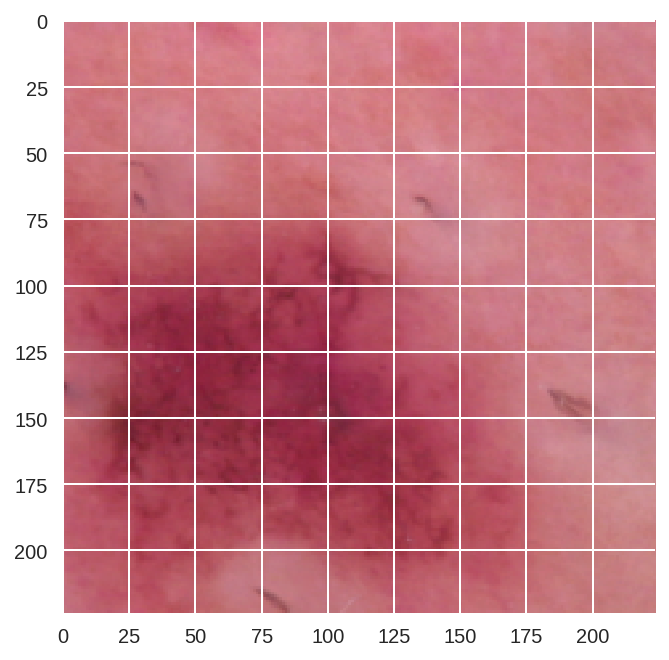

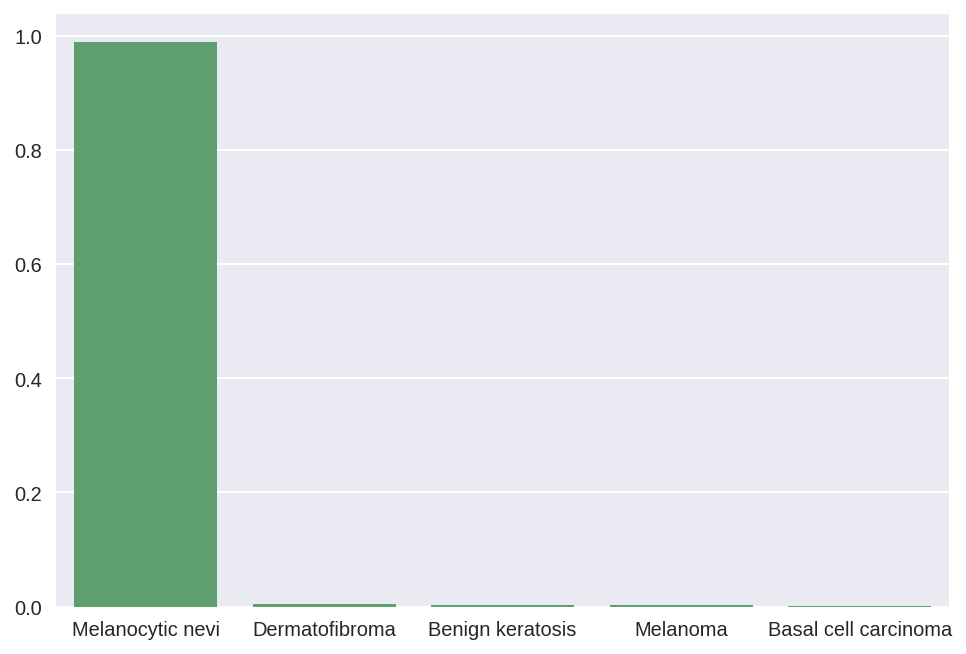

In [0]:
# Display an image along with the top 5 classes
# Importing seaborn for plotting
import seaborn as sns

#Give image path
image_path = 'drive/My Drive/Cancer/test_dir/6/ISIC_0024309.jpg' #Change path of image to get different image.

# Setting up 2 sub plot
plt.figure(figsize = (8,12))
ax = plt.subplot(2,1,1)

# Used to give title
cancer_name = image_path.split('/')[4]
title_cancer = can_to_name[cancer_name]

# Plot flower
img = process_image(image_path)
imshow(img, ax, title = title_cancer);

# used for prediction
probability, labels, cancers = predict(image_path, model) 

# Top 5 predicated flower name on barplot
plt.figure(figsize=(8,12))
plt.subplot(2,1,2)
sns.barplot(x=cancers, y=probability, color=sns.color_palette()[1]);
plt.show()


## Future Scope

In future, we can train with more accurate pretrained model and increase the accuracy of the model. Later, it can be given a form of a mobile app which can accessible everywhere. In this way, it can help people to fight with skin cancer by recognizing and detecting it in early stage. Here is a small prototype of final skin cancer classifier app. 
!(https://share.proto.io/LPE8ES/)
![](1 - Screen 1.png)


## Thanks

Lastly, I would like to thank Brenda & Chaitara of Udacity and amazing 10000 people of scholarship for motivation and support during learning and building the model. Without their help, it would not be possible for me to explore the ocean of deep learning & artificial intelligence.

Really Udacity & Facebook's PyTorch Challenge scholarship is a great opportunity for learning and doing.

#StayUdacious #PytorchScholar #UdacityPytorch